<a href="https://colab.research.google.com/github/KevinFan9729/Generative-Adversarial-Network-Image/blob/master/GAN_Celebrity_Face_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
#from __future__ import print_function
import argparse
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#Setting the seeds of random number generator and torch for reproducibility
seed = 999
random.seed(seed)
torch.manual_seed(seed)

In [51]:
import os
dataRoot=os.path.abspath("/content/drive/My Drive/celeba/")
os.chdir(dataRoot)
print("the current directory is: %s" % dataRoot)

the current directory is: /content/drive/My Drive/celeba


In [52]:
print("This should display-->  img_align_celeba/")
%ls


This should display-->  img_align_celeba/
img_align_celeba/


In [0]:
##uploading data to the web drive. Only needs to be executed once
#from zipfile import ZipFile
#import zipfile
#def unzip(source_filename):
#    with zipfile.ZipFile(source_filename) as zf:
#        zf.extractall()

#fileName="img_align_celeba.zip"
#unzip(fileName)

*  **dataRoot**: the path of dataset folder
*  **wokers**: the number of worker threads for loading the data with the data loader
*   **batchSize**: the batch size used in tranning
*   **imageSize**: the size of the images used for tranning
*   **nc**: the number of color channel of the image 
*   **nz**: the length of laten vector
*   **ngf**: relates to the depth of feature maps carried through the generator
*   **ndf**: sets the depth of freature mpas propagated through the discriminator 


In [0]:
workers=2
batchSize=128
imageSize=64 #64*64 image
nc=3 #3 channels RGB image
nz=100 #size of the latent vector. The sizer of the generator input
ngf=64 #size of generator feature map
ndf=64 #size of freature maps in discriminator
num_epochs=5
lr=0.0002
beta1=0.5 #Adam beta1
ngpu=1 #number of GPUs available. Set this to 0 for cpu

In [54]:
dataRoot

'/content/drive/My Drive/celeba'

In [56]:
#dataset creation 
dataset=dset.ImageFolder(root=dataRoot,transform=transforms.Compose([transforms.Resize(imageSize),
                                                                     transforms.CenterCrop(imageSize),
                                                                     transforms.ToTensor(),
                                                                     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
#Note, transforms.Normalize((mean),(std)) needs the same number of inputs as the target image/data channel number
#In this case we are dealing with 3*64*64 RGB images. So the number of channels is 3

print("The Summary of dataset:\n")
dataset

The Summary of dataset:



Dataset ImageFolder
    Number of datapoints: 44020
    Root location: /content/drive/My Drive/celeba
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

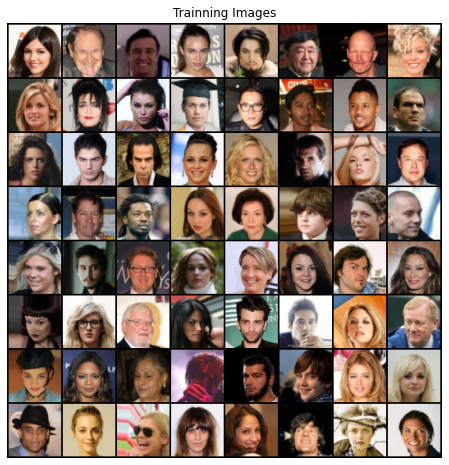

In [57]:
#dataloader Creation
dataloader=torch.utils.data.DataLoader(dataset=dataset,batch_size=batchSize,shuffle=True,num_workers=workers)
#determine which device to run
device=torch.device("cuda:0" if (torch.cuda.is_available() and ngpu>0)else "cpu")#GPU 0

real_batch=next(iter(dataloader))
plt.figure(figsize=(8,8))#8*8 new figure
plt.axis("off")
plt.title("Trainning Images")
plt.imshow(X=np.transpose(vutils.make_grid(tensor=real_batch[0][64:].to(device),padding=2,normalize=True).cpu(),(1,2,0)))#X=(M, N, 3): an image with RGB values (0-1 float or 0-255 int).

In [0]:
#All weights were initialized from a zero-centered Normal distribution 
#with standard deviation 0.02

def weights_init(m):
  classname=m.__class__.__name__#reference the class of current instance
  if classname.find('Conv')!=-1:
    nn.init.normal_(m.weight.data,0.0,0.02 )
  elif classname.find('BatchNorm')!=-1:
    nn.init.normal_(m.weight.data,1.0,0.02 )
    nn.init.constant_(m.bias.data,0)

![alt text](https://miro.medium.com/max/2912/1*yYjTtqTrW_ZJbm-pQyN70g.png)

Architecture guidelines for stable Deep Convolutional GANs

*   Replace any pooling layers with strided convolutions (discriminator) and fractional-strided
convolutions (generator).
*   Use batchnorm in both the generator and the discriminator.
*   Remove fully connected hidden layers for deeper architectures.
*   Use ReLU activation in generator for all layers except for the output, which uses Tanh.
*   Use LeakyReLU activation in the discriminator for all layers.




In [0]:
#nc=3 #3 channels RGB image
#nz=100 #size of the latent vector. The size of the generator input
#ngf=64 #size of generator feature map
#ndf=64 #size of freature maps in discriminator

class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator,self).__init__()
    self.ngpu=ngpu
    self.main=nn.Sequential(
        nn.ConvTranspose2d(in_channels=nz,out_channels=ngf*8,kernel_size=4,stride=1,padding=0,bias=False),
        nn.BatchNorm2d(ngf*8),
        nn.ReLU(inplace=True),
        # state size (ngf*8)*4*4


        nn.ConvTranspose2d(ngf*8,ngf*4,4,2,1,bias=False),
        nn.BatchNorm2d(ngf*4),
        nn.ReLU(True),
        # state size (ngf*4)*8*8

        nn.ConvTranspose2d(ngf*4,ngf*2,4,2,1,bias=False),
        nn.BatchNorm2d(ngf*2),
        nn.ReLU(True),
        # state size (ngf*2)*16*16


        nn.ConvTranspose2d(ngf*2,ngf,4,2,1,bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),
        # state size (ngf)*32*32


        nn.ConvTranspose2d(ngf,nc,4,2,1,bias=True),
        nn.Tanh()
        # state size (nc)*64*64
    )
  def forward(self, input):
    return self.main(input)

In [85]:
netG=Generator(ngpu).to(device)

##if more gpu is avaiable, perform parallel computing
#if(device.type=='cuda') and (ngpu>1):
#  netG=nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)# apply loops over each child Module and applies a function to it
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)


In [0]:
#nc=3 #3 channels RGB image
#nz=100 #size of the latent vector. The sizer of the generator input
#ngf=64 #size of generator feature map
#ndf=64 #size of freature maps in discriminator

class Discriminator(nn.Module):
  def __init__(self,ngpu):
    super(Discriminator, self).__init__()
    self.ngpu=ngpu
    self.main=nn.Sequential(
        #input is 3*64*64
        nn.Conv2d(nc,ndf,4,2,1,bias=False),
        nn.LeakyReLU(0.2,inplace=True),
        
        #state size (ndf)*32*32
        nn.Conv2d(ndf,ndf*2,4,2,1,bias=False),
        nn.BatchNorm2d(ndf*2),
        nn.LeakyReLU(0.2,inplace=True),

        #state size (ndf*2)*16*16
        nn.Conv2d(ndf*2,ndf*4,4,2,1,bias=False),
        nn.BatchNorm2d(ndf*4),
        nn.LeakyReLU(0.2,inplace=True),

        #state size (ndf*4)*8*8
        nn.Conv2d(ndf*4,ndf*8,4,2,1,bias=False),
        nn.BatchNorm2d(ndf*8),
        nn.LeakyReLU(0.2,inplace=True),
        
        #state size (ndf*8)*4*4
        nn.Conv2d(ndf*8,1,4,1,0,bias=False),
        nn.Sigmoid()

    )

  def forward(self, input):
    return self.main(input)

In [87]:
netD=Discriminator(ngpu).to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [0]:
criterion=nn.BCELoss() #binary cross entropy loss

#batch of laten vectors for generator progress visualization
fixed_noise=torch.randn(64,nz,1,1,device=device)

real_label=1
fake_label=0

optimizerD=optim.Adam(netD.parameters(),lr=lr,betas=(beta1,0.9990))
optimizerG=optim.Adam(netG.parameters(),lr=lr,betas=(beta1,0.9990))

*   **Loss_D** - discriminator loss calculated as the sum of losses for the all real and all fake batches (log(D(x))+log(D(G(z)))).
*   **Loss_G** - generator loss calculated as log(D(G(z)))
*   **D(x)** - the average output (across the batch) of the discriminator for the all real batch. This should start close to 1 then theoretically converge to 0.5 when G gets better. Think about why this is.(discriminator cannot determine whether the data is fake or not. This is the optimal stage)
*   **D(G(z))** - average discriminator outputs for the all fake batch. The first number is before D is updated and the second number is after D is updated. These numbers should start near 0 and converge to 0.5 as G gets better. Think about why this is.(again, if D can only guess evenly as G gets better, that means G is at the optimal stage)

In [0]:
#Trainning Loop

#Lists to keep track of progress
img_list=[]
G_losses=[]
D_losses=[]
iters=0

print("Starting Training Loop...")
#For each epoch
for epoch in range(num_epochs):
  #For each batch in the dataloader
  for i, data in enumerate(dataloader,0):#Note enumerate allows automatic counter while looping
      ###############################
      #(1) Update D network: maximize log(D(x))+log(1-D(G(z)))
      ################################
      ## Train with all-realbatch
      netD.zero_grad()#Set the gradient of all model parameter to zero
      # Format batch
      real_cpu=data[0].to(device)
      b_size=real_cpu.size(0)
      label=torch.full((b_size,),real_label,device=device)
      #Forward pass real batch through D
      output=netD(real_cpu).view(-1) #Note: The view function is meant to reshape the tensor
      #Calcuate loss on all-real batch
      errD_real=criterion(output,label)#cross entropy loss between output and labels
      #Calculate gradients for D in backward pass
      errD_real.backward()
      D_x=output.mean().item()#.item() get a python number from a single numbered tensor

      ## Train with all-fake batch
      # Generate batch of latent vectors
      noise=torch.randn(b_size,nz,1,1,device=device)
      # Generate fake image batch with G
      fake=netG(noise)
      label.fill_(fake_label)#inplace fill the updated fake labels
      # Classify all fake batch with D
      output=netD(fake.detach()).view(-1)#detach disable differentiation. Stop tracking gradients
      # detach here is necessary to aviod forward-passing the noise through G when we actually update
      # the generator
      # Calcuate D's loss on the all-fake batch
      errD_fake =criterion(output, label)
      # Calculate the gradients for this batch
      errD_fake.backward()
      D_G_z1=output.mean().item()
      # Add gradients from the all-real and all-fake batches
      errD=errD_real+errD_fake
      #update D
      optimizerD.step()

      ###############################
      #(2) Update G network: maximize log(D(G(z)))
      ###############################
      netG.zero_grad()
      label.fill_(real_label) #fake labels are real for generator cost
      #Since we just updated D, perform foward pass of all-fake batch through D
      output=netD(fake).view(-1)
      #Calcuate G's loss based on updated D's output 
      errG=criterion(output,label)
      #Calcuate gradients for G
      errG.backward()
      D_G_z2=output.mean().item()
      #update G
      optimizerG.step()

      #Output traning stats
      if i%50==0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
        % (epoch, num_epochs, i, len(dataloader),
           errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
      
      #Save Losses for plotting later
      G_losses.append(errG.item())
      D_losses.append(errD.item())



      #Check how the generator is doing by saving G's output on fixed_noise
      if(iters%500==0) or((epoch==num_epochs-1)) and (i==len(dataloader)-1):
        with torch.no_grad():
          fake=netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake,padding=2,normalize=True))
      
      iters+=1




